# For PSEA (java, locally run on a PC)

In [1]:
import pandas as pd

In [2]:
WTLD = pd.read_csv("WTLD_combined.csv")
WTDD = pd.read_csv("WTDD_combined.csv")
MTLD = pd.read_csv("MTLD_combined.csv")
MTDD = pd.read_csv("MTDD_combined.csv")

In [ ]:
cd "/Users/pyonghwakim/Dropbox @RU Dropbox/Pyonghwa Kim/snRNA-seq (w: Cao lab)/Circadian analysis/PSEA-master"
java -jar PSEA1.1_VectorGraphics.jar
#/Users/pyonghwakim/Dropbox @RU Dropbox/Pyonghwa Kim/snRNA-seq (w: Cao lab)/Circadian analysis/PSEA-master/c5.all.works.gmt

# After PSEA

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Load Files and Add Condition Information ---
include_terms = [
    "Metabolism",                                                               
    "Cellular Process",                                                         
    "Development",                                                             
    "Localization",                                                           
    "Biological Regulation",                                             
   # "Immune Response",                                              
    "Homeostasis",                                             
    "Response To Stimulus",                                               
    "Multicellular Organismal Process",                                   
   # "Growth",                                              
   # "Reproduction"
]

def load_file(filename, condition):
    # Read the CSV file.
    df = pd.read_csv(filename)
    # Filter rows to include only the desired GO terms.
    #df = df[df['Cluster'].isin(include_terms)].copy()
    # Add the Condition column.
    df['Condition'] = condition
    return df

# Load each file. These files already include a "CellType" column.
df_WTLD = load_file("plot_data_filtered_WTLD.csv", condition="WTLD")
df_WTDD = load_file("plot_data_filtered_WTDD.csv", condition="WTDD")
df_MTLD = load_file("plot_data_filtered_MTLD.csv", condition="MTLD")
df_MTDD = load_file("plot_data_filtered_MTDD.csv", condition="MTDD")

# --- Step 2: Stack the Data ---
# Concatenate all data vertically so that each row is an individual datapoint.
df_long = pd.concat([df_WTLD, df_WTDD, df_MTLD, df_MTDD], ignore_index=True)

# Rename the value column for clarity.
df_long = df_long.rename(columns={"Vector-average value": "Value"})

df_long = df_long[~df_long['GO'].str.contains('HP', na=False)].copy()

# Compute a continuous time value by adding an offset based on Condition.
offsets = {"WTLD": 0, "WTDD": 24, "MTLD": 48, "MTDD": 72}
df_long["ContinuousTime"] = df_long["Value"] + df_long["Condition"].map(offsets)

print(df_long)

                          Cluster  \
1                      Metabolism   
3                             NaN   
4                Cellular Process   
5                             NaN   
7                Cellular Process   
...                           ...   
16952                  Metabolism   
16954  Cellular Anatomical Entity   
16955                  Metabolism   
16956                         NaN   
16957                  Metabolism   

                                                  Set ID  Set N  \
1                    GOBP_GLYCOPROTEIN_METABOLIC_PROCESS      3   
3                       GOBP_PITUITARY_GLAND_DEVELOPMENT      3   
4      GOBP_NEGATIVE_REGULATION_OF_CELL_POPULATION_PR...      3   
5                          GOBP_DIENCEPHALON_DEVELOPMENT      3   
7                  GOBP_REGULATION_OF_PEPTIDASE_ACTIVITY      3   
...                                                  ...    ...   
16952              GOBP_CELLULAR_AMIDE_METABOLIC_PROCESS     53   
16954              

In [7]:
from goatools.obo_parser import GODag
import pandas as pd
import re

# Load the GO DAG with relationships
godag = GODag("go-basic.obo", optional_attrs={'relationship'})

# Function to extract GO ID from a GO term string (e.g., "Some term (GO:0008150)")
def extract_go_id(term_string):
    match = re.search(r'\(GO:\d+\)', term_string)
    if match:
        return match.group(0)[1:-1]  # Remove parentheses and return GO ID
    return None

# Extract GO IDs into a new column 'GO_ID'
df_long['GO_ID'] = df_long['GO']

# Function to retrieve multiple hierarchical parent GO terms (up to a specified number of levels)
def get_multiple_parent_terms(go_id, levels=11):
    if not go_id or go_id not in godag:
        return [None] * levels
    result = []
    current_id = go_id
    for _ in range(levels):
        # If there are no parents, stop the loop
        if not godag[current_id].parents:
            break
        # Choose the parent with the smallest depth (most general)
        parent = min(godag[current_id].parents, key=lambda p: p.depth)
        result.append(parent.id)
        current_id = parent.id
    # Pad the result if fewer than 'levels' parents were found
    result.extend([None] * (levels - len(result)))
    return result

# Apply the function to create a DataFrame of parent terms
parent_terms_df = df_long['GO_ID'].apply(lambda x: pd.Series(get_multiple_parent_terms(x)))
parent_terms_df.columns = [
    'Higher_Parent_Term', 'Second_Higher_Parent_Term', 
    'Third_Higher_Parent_Term', 'Fourth_Higher_Parent_Term', 
    'Fifth_Higher_Parent_Term', 'Sixth_Higher_Parent_Term',
    'Seventh_Higher_Parent_Term','Eighth_Higher_Parent_Term',
    'Ninth_Higher_Parent_Term','Tenth_Higher_Parent_Term',
    'Eleventh_Higher_Parent_Term'
]

# Merge the parent terms back into df_long (this avoids duplicate 'Highest_Parent_Term' columns)
df_long = pd.concat([df_long.drop(columns=['Higher_Parent_Term'], errors='ignore'), parent_terms_df], axis=1)

# Define the 'Cluster' column based on the highest-level parent term
df_long['Cluster'] = df_long['Higher_Parent_Term']

# Debug: Print a sample to verify the new columns
print(df_long[['GO', 'GO_ID', 'Cluster', 
    'Higher_Parent_Term', 'Second_Higher_Parent_Term', 
    'Third_Higher_Parent_Term', 'Fourth_Higher_Parent_Term', 
    'Fifth_Higher_Parent_Term', 'Sixth_Higher_Parent_Term',
    'Seventh_Higher_Parent_Term','Eighth_Higher_Parent_Term',
    'Ninth_Higher_Parent_Term','Tenth_Higher_Parent_Term',
    'Eleventh_Higher_Parent_Term']].head())

# Optionally, save the updated DataFrame for inspection
#df_long.to_csv("df_long_with_clusters.csv", index=False)
#print("Saved updated DataFrame as df_long_with_clusters.csv")

df_long = df_long.loc[:, ~df_long.columns.duplicated()]

go-basic.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms; optional_attrs(relationship)
           GO       GO_ID     Cluster Higher_Parent_Term  \
1  GO:0009100  GO:0009100  GO:1901135         GO:1901135   
3  GO:0021983  GO:0021983  GO:0048732         GO:0048732   
4  GO:0008285  GO:0008285  GO:0048523         GO:0048523   
5  GO:0021536  GO:0021536  GO:0048856         GO:0048856   
7  GO:0052547  GO:0052547  GO:0051336         GO:0051336   

  Second_Higher_Parent_Term Third_Higher_Parent_Term  \
1                GO:0008152               GO:0009987   
3                GO:0048513               GO:0048856   
4                GO:0050794               GO:0050789   
5                GO:0032502               GO:0008150   
7                GO:0050790               GO:0065009   

  Fourth_Higher_Parent_Term Fifth_Higher_Parent_Term Sixth_Higher_Parent_Term  \
1                GO:0008150                     None                     None   
3                GO:0032502               GO:0008150      

In [8]:
df_long['Current_Term'] = df_long['GO_ID'].copy()

In [9]:
# List the columns that contain GO IDs
go_columns = [
    'Current_Term', 
    'Higher_Parent_Term', 'Second_Higher_Parent_Term', 
    'Third_Higher_Parent_Term', 'Fourth_Higher_Parent_Term', 
    'Fifth_Higher_Parent_Term', 'Sixth_Higher_Parent_Term',
    'Seventh_Higher_Parent_Term','Eighth_Higher_Parent_Term',
    'Ninth_Higher_Parent_Term','Tenth_Higher_Parent_Term',
    'Eleventh_Higher_Parent_Term'
]

def format_go_term(go_id):
    # If the value is missing or None, leave it as is
    if pd.isna(go_id) or go_id is None:
        return go_id
    # If the GO ID is in the DAG, format with its name; otherwise, just return the GO ID.
    if go_id in godag:
        return f"{godag[go_id].name} ({go_id})"
    else:
        return go_id

# Apply the formatting to each specified column
for col in go_columns:
    if col in df_long.columns:
        df_long[col] = df_long[col].apply(format_go_term)

# Optionally, print a sample of the formatted columns
print(df_long[go_columns].head())


                                        Current_Term  \
1        glycoprotein metabolic process (GO:0009100)   
3           pituitary gland development (GO:0021983)   
4  negative regulation of cell population prolife...   
5              diencephalon development (GO:0021536)   
7      regulation of peptidase activity (GO:0052547)   

                                  Higher_Parent_Term  \
1  carbohydrate derivative metabolic process (GO:...   
3                     gland development (GO:0048732)   
4  negative regulation of cellular process (GO:00...   
5      anatomical structure development (GO:0048856)   
7      regulation of hydrolase activity (GO:0051336)   

                       Second_Higher_Parent_Term  \
1                 metabolic process (GO:0008152)   
3          animal organ development (GO:0048513)   
4    regulation of cellular process (GO:0050794)   
5             developmental process (GO:0032502)   
7  regulation of catalytic activity (GO:0050790)   

             

In [113]:
df_long.to_csv("df_long_with_clusters.csv", index=False)
print("Saved updated DataFrame as df_long_with_clusters.csv")


Saved updated DataFrame as df_long_with_clusters.csv


In [114]:
from goatools.obo_parser import GODag
import pandas as pd
import numpy as np
import re

# Load the GO DAG with relationships
godag = GODag("go-basic.obo", optional_attrs={'relationship'})

# Function to extract GO ID from a GO term string (if needed)
def extract_go_id(term_string):
    match = re.search(r'\(GO:\d+\)', term_string)
    if match:
        return match.group(0)[1:-1]  # Remove parentheses and return GO ID
    return None

# (Assuming df_long already exists and contains a 'GO' column with GO IDs.)
# For example, if df_long['GO'] already contains strings like "GO:0048813", then:
df_long['GO_ID'] = df_long['GO']

# Function to retrieve multiple hierarchical parent GO terms (up to a specified number of levels)
def get_multiple_parent_terms(go_id, levels=11):
    if not go_id or go_id not in godag:
        return [None] * levels
    result = []
    current_id = go_id
    for _ in range(levels):
        if not godag[current_id].parents:
            break
        # Choose the parent with the smallest depth (i.e. the most general)
        parent = min(godag[current_id].parents, key=lambda p: p.depth)
        result.append(parent.id)
        current_id = parent.id
    result.extend([None] * (levels - len(result)))
    return result

# Function to compute the Cluster GO term: the term just below biological_process (GO:0008150)
def get_cluster_term(go_id):
    # If the GO ID is not valid or not in the DAG, return NaN.
    if not go_id or go_id not in godag:
        return np.nan
    # If the GO term itself is biological_process, we can't define a sub-term.
    if go_id == "GO:0008150":
        return np.nan
    # Get the chain of parent terms from immediate parent upward.
    chain = get_multiple_parent_terms(go_id, levels=11)
    # Filter out any None entries.
    chain = [term for term in chain if term is not None]
    # Check if biological_process is in the chain.
    if "GO:0008150" in chain:
        idx = chain.index("GO:0008150")
        # If GO:0008150 is the immediate parent (index 0), then the current GO term is directly below biological_process.
        if idx == 0:
            return go_id
        else:
            # Return the term immediately below biological_process in the chain.
            return chain[idx - 1]
    else:
        # GO:0008150 is not in the parent chain, so set Cluster to NaN.
        return np.nan

# (Optional) Helper function to format a GO term as "GO term name (GO:####)" using the GO DAG.
def format_go_term(go_id):
    if not go_id or pd.isna(go_id):
        return go_id
    if go_id in godag:
        return f"{godag[go_id].name} ({go_id})"
    return go_id

# Compute the Cluster column:
df_long['Cluster'] = df_long['GO_ID'].apply(get_cluster_term)

# Optionally, format the Cluster column for a nicer display:
df_long['Cluster'] = df_long['Cluster'].apply(format_go_term)

# Debug: Print a sample to verify the new Cluster column.
print(df_long[['GO_ID', 'Cluster']].head())

# Optionally, save the updated DataFrame for inspection.
df_long.to_csv("df_long_with_updated_clusters.csv", index=False)
print("Saved updated DataFrame as df_long_with_updated_clusters.csv")


go-basic.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms; optional_attrs(relationship)
        GO_ID                             Cluster
1  GO:0009100       cellular process (GO:0009987)
3  GO:0021983  developmental process (GO:0032502)
4  GO:0008285  biological regulation (GO:0065007)
5  GO:0021536  developmental process (GO:0032502)
7  GO:0052547  biological regulation (GO:0065007)
Saved updated DataFrame as df_long_with_updated_clusters.csv


In [115]:
from goatools.obo_parser import GODag
import pandas as pd
import numpy as np
import re

# Load the GO DAG with relationships
godag = GODag("go-basic.obo", optional_attrs={'relationship'})

# Function to extract GO ID from a GO term string (if needed)
def extract_go_id(term_string):
    match = re.search(r'\(GO:\d+\)', term_string)
    if match:
        return match.group(0)[1:-1]  # Remove parentheses and return GO ID
    return None

# (Assuming df_long already exists and contains a 'GO' column with GO IDs.)
# For example, if df_long['GO'] already contains strings like "GO:0048813", then:
df_long['GO_ID'] = df_long['GO']

# Function to retrieve multiple hierarchical parent GO terms (up to a specified number of levels)
def get_multiple_parent_terms(go_id, levels=11):
    if not go_id or go_id not in godag:
        return [None] * levels
    result = []
    current_id = go_id
    for _ in range(levels):
        if not godag[current_id].parents:
            break
        # Choose the parent with the smallest depth (i.e. the most general)
        parent = min(godag[current_id].parents, key=lambda p: p.depth)
        result.append(parent.id)
        current_id = parent.id
    result.extend([None] * (levels - len(result)))
    return result

# Function to compute the Cluster GO term: the term just below biological_process (GO:0008150)
def get_cluster_term(go_id):
    # If the GO ID is not valid or not in the DAG, return NaN.
    if not go_id or go_id not in godag:
        return np.nan
    # If the GO term itself is biological_process, we can't define a sub-term.
    if go_id == "GO:0008150":
        return np.nan
    # Get the chain of parent terms from immediate parent upward.
    chain = get_multiple_parent_terms(go_id, levels=11)
    # Filter out any None entries.
    chain = [term for term in chain if term is not None]
    # Check if biological_process is in the chain.
    if "GO:0008150" in chain:
        idx = chain.index("GO:0008150")
        # If GO:0008150 is the immediate parent (index 0), then the current GO term is directly below biological_process.
        if idx == 0:
            return go_id
        else:
            # Return the term immediately below biological_process in the chain.
            return chain[idx - 1]
    else:
        # GO:0008150 is not in the parent chain, so set Cluster to NaN.
        return np.nan

# (Optional) Helper function to format a GO term as "GO term name (GO:####)" using the GO DAG.
def format_go_term(go_id):
    if not go_id or pd.isna(go_id):
        return go_id
    if go_id in godag:
        return f"{godag[go_id].name} ({go_id})"
    return go_id

# Compute the Cluster column:
df_long['Cluster'] = df_long['GO_ID'].apply(get_cluster_term)

# Optionally, format the Cluster column for a nicer display:
df_long['Cluster'] = df_long['Cluster'].apply(format_go_term)

# Debug: Print a sample to verify the new Cluster column.
print(df_long[['GO_ID', 'Cluster']].head())

# Optionally, save the updated DataFrame for inspection.
df_long.to_csv("df_long_with_updated_clusters.csv", index=False)
print("Saved updated DataFrame as df_long_with_updated_clusters.csv")


go-basic.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms; optional_attrs(relationship)
        GO_ID                             Cluster
1  GO:0009100       cellular process (GO:0009987)
3  GO:0021983  developmental process (GO:0032502)
4  GO:0008285  biological regulation (GO:0065007)
5  GO:0021536  developmental process (GO:0032502)
7  GO:0052547  biological regulation (GO:0065007)
Saved updated DataFrame as df_long_with_updated_clusters.csv


In [4]:
df_long = pd.read_csv("df_long_with_updated_clusters.csv")

In [6]:
print(df_long['Cluster'].unique().tolist())

['cellular process (GO:0009987)', 'developmental process (GO:0032502)', 'biological regulation (GO:0065007)', nan, 'localization (GO:0051179)', 'response to stimulus (GO:0050896)', 'immune system process (GO:0002376)', 'growth (GO:0040007)', 'homeostatic process (GO:0042592)', 'multicellular organismal process (GO:0032501)', 'biological process involved in interspecies interaction between organisms (GO:0044419)', 'rhythmic process (GO:0048511)', 'reproductive process (GO:0022414)', 'locomotion (GO:0040011)', 'viral process (GO:0016032)', 'pigmentation (GO:0043473)', 'biological process involved in intraspecies interaction between organisms (GO:0051703)']


In [5]:
# Count the number of rows per cluster (including NaN values)
cluster_counts = df_long['Cluster'].value_counts(dropna=False)
print("Number of rows per Cluster:")
print(cluster_counts)


Number of rows per Cluster:
Cluster
NaN                                                                                       3599
biological regulation (GO:0065007)                                                        2715
cellular process (GO:0009987)                                                             2581
localization (GO:0051179)                                                                  658
developmental process (GO:0032502)                                                         545
response to stimulus (GO:0050896)                                                          417
multicellular organismal process (GO:0032501)                                              294
immune system process (GO:0002376)                                                         133
homeostatic process (GO:0042592)                                                            81
reproductive process (GO:0022414)                                                           54
growth (GO:004

In [6]:
# Define the mapping dictionary
cluster_mapping = {
    "biological regulation (GO:0065007)": "Biological Regulation",
    "cellular process (GO:0009987)": "Cellular Process",
    "developmental process (GO:0032502)": "Development",
    "localization (GO:0051179)": "Localization",
    "response to stimulus (GO:0050896)": "Response to Stimulus",
    "multicellular organismal process (GO:0032501)": "Multicelllular Organismal Process",
    "immune system process (GO:0002376)": "Immune System",
    "homeostatic process (GO:0042592)": "Homeostasis",
    #"reproductive process (GO:0022414)": "Reproduction"
}

df_long['Cluster_converted'] = np.nan

# Create the new column by mapping the values
df_long['Cluster_converted'] = df_long['Cluster'].map(cluster_mapping)

# Optionally, check the unique values in the new column
print(df_long['Cluster_converted'].unique())


['Cellular Process' 'Development' 'Biological Regulation' nan
 'Localization' 'Response to Stimulus' 'Immune System' 'Homeostasis'
 'Multicelllular Organismal Process']


In [7]:
clusters = df_long["Cluster_converted"].dropna().unique()

In [9]:
import pandas as pd

# Define the GO hierarchy columns
go_columns = [
    'Current_Term', 
    'Higher_Parent_Term', 'Second_Higher_Parent_Term', 
    'Third_Higher_Parent_Term', 'Fourth_Higher_Parent_Term', 
    'Fifth_Higher_Parent_Term', 'Sixth_Higher_Parent_Term',
    'Seventh_Higher_Parent_Term','Eighth_Higher_Parent_Term',
    'Ninth_Higher_Parent_Term','Tenth_Higher_Parent_Term',
    'Eleventh_Higher_Parent_Term'
]

def get_direct_child_counts(df, parent_term, go_columns):
    """
    For each row in df, if one of the columns in go_columns (except the first)
    equals the parent_term, then the value in the column immediately to its left
    is considered a direct child term of parent_term.
    Returns a Series with counts for each direct child term.
    """
    child_counts = {}
    # Start from the second column (index 1) since index 0 has no preceding column
    for i in range(1, len(go_columns)):
        col = go_columns[i]
        prev_col = go_columns[i-1]
        # Create a boolean mask where the current column equals the parent_term
        mask = df[col] == parent_term
        # Extract the candidate child terms from the previous column
        child_terms = df.loc[mask, prev_col]
        # Count frequencies and aggregate into child_counts dictionary
        counts = child_terms.value_counts(dropna=False)
        for term, count in counts.items():
            # Optionally, ignore NaN or the parent_term itself if it appears
            if pd.isna(term) or term == parent_term:
                continue
            child_counts[term] = child_counts.get(term, 0) + count
    return pd.Series(child_counts).sort_values(ascending=False)

# Define the high-level terms (using your formatted strings)
cellular_process = "cellular process (GO:0009987)"
biological_regulation = "biological regulation (GO:0065007)"
multicellular_org = "multicellular organismal process (GO:0032501)"
nerv_org = "nervous system process (GO:0050877)"
stimulus_org = "response to stimulus (GO:0050896)"

# Get the direct child term counts for each high-level term
cellular_child_counts = get_direct_child_counts(df_long, cellular_process, go_columns)
bio_reg_child_counts = get_direct_child_counts(df_long, biological_regulation, go_columns)
multi_org_child_counts = get_direct_child_counts(df_long, multicellular_org, go_columns)
nerv_counts = get_direct_child_counts(df_long, nerv_org, go_columns)
stimulus_counts = get_direct_child_counts(df_long, stimulus_org, go_columns)

# Print the results
print("Direct child terms of cellular process (GO:0009987):")
print(cellular_child_counts)
print("\nDirect child terms of biological regulation (GO:0065007):")
print(bio_reg_child_counts)
print("\nDirect child terms of multicellular organismal process (GO:0032501):")
print(multi_org_child_counts)
print("\nDirect child terms of nervous system process (GO:0050877):")
print(nerv_counts)
print("\nDirect child terms of response to stimulus (GO:0050896):")
print(stimulus_counts)


Direct child terms of cellular process (GO:0009987):
metabolic process (GO:0008152)                                                      1016
cellular component organization or biogenesis (GO:0071840)                           479
signal transduction (GO:0007165)                                                     211
cellular developmental process (GO:0048869)                                          202
cellular response to stimulus (GO:0051716)                                           108
cell communication (GO:0007154)                                                       77
vesicle-mediated transport (GO:0016192)                                               72
transmembrane transport (GO:0055085)                                                  54
cell cycle process (GO:0022402)                                                       52
cell motility (GO:0048870)                                                            44
cell adhesion (GO:0007155)                               

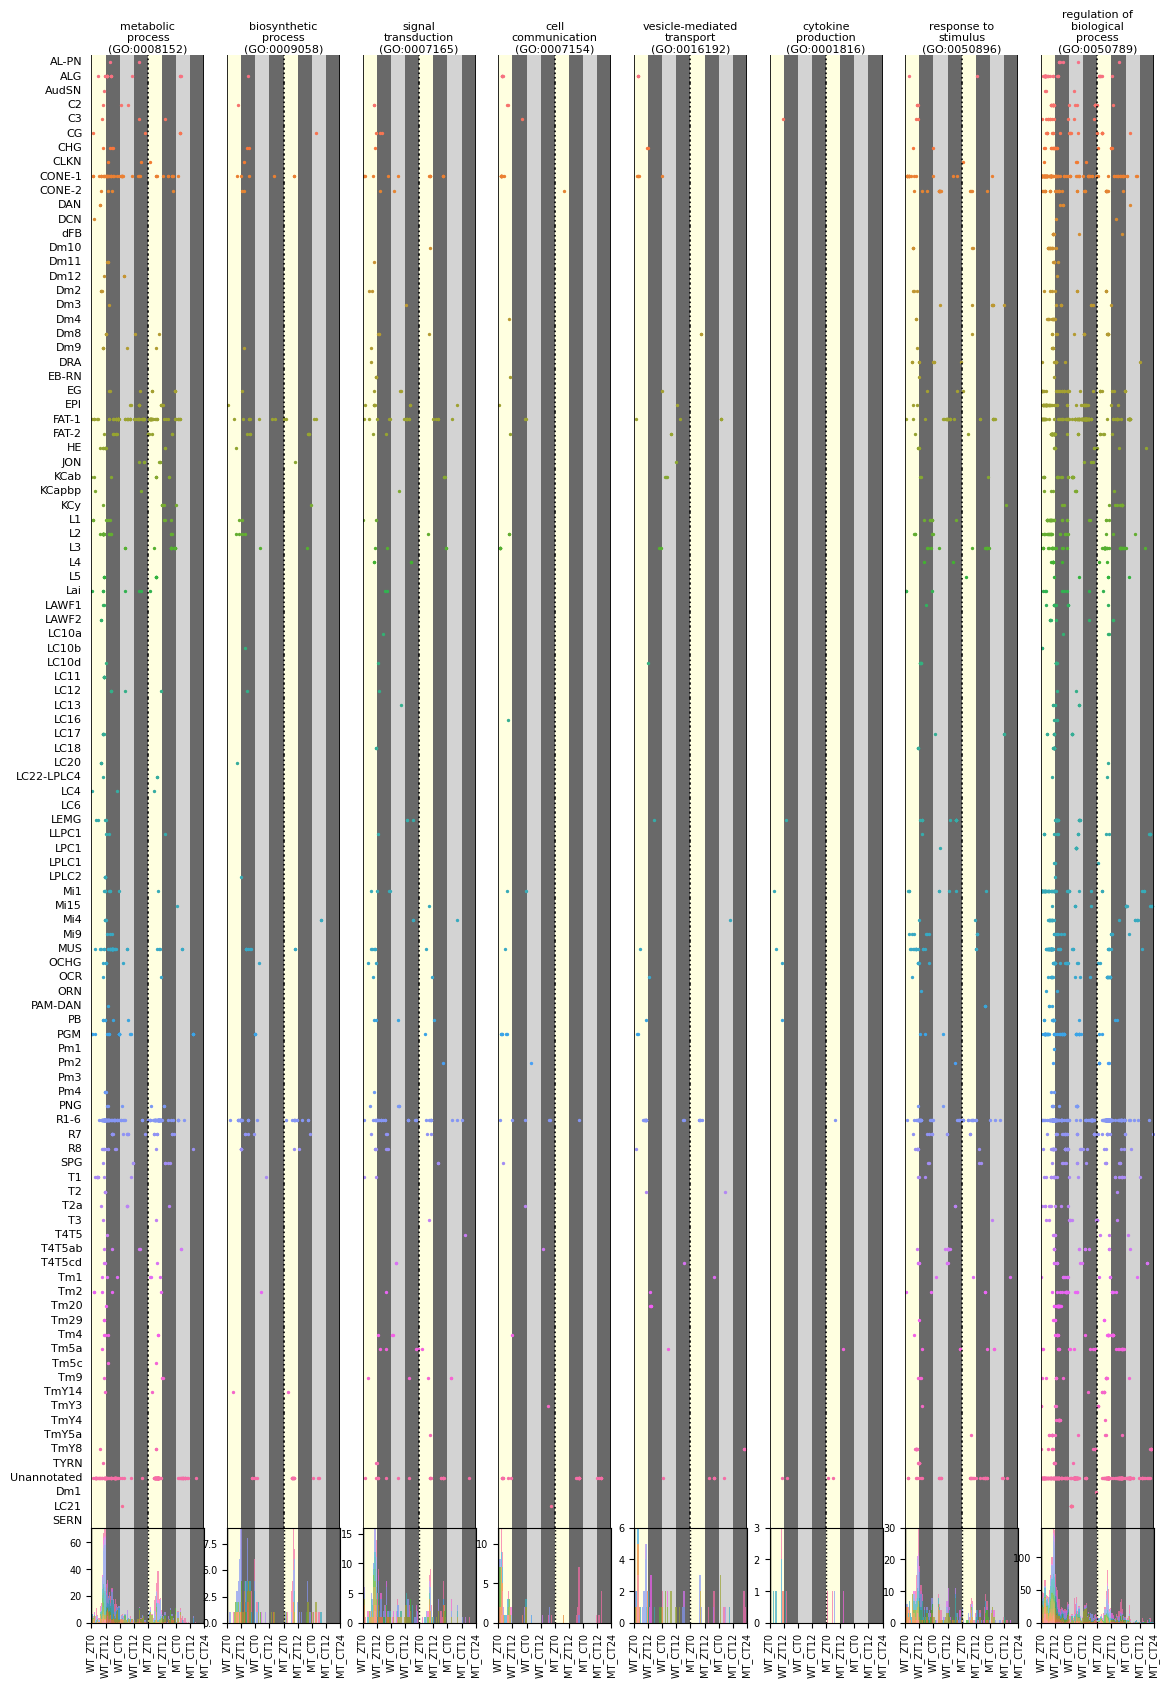

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
import matplotlib.gridspec as gridspec

# ----------------------------------------------------------------------------
# 1) Remove LC13 and define GO columns, etc.
# ----------------------------------------------------------------------------
#df_long = df_long[df_long["CellType"] != "LC13"]

go_columns = [
    'Current_Term', 
    'Higher_Parent_Term', 'Second_Higher_Parent_Term', 
    'Third_Higher_Parent_Term', 'Fourth_Higher_Parent_Term', 
    'Fifth_Higher_Parent_Term', 'Sixth_Higher_Parent_Term',
    'Seventh_Higher_Parent_Term','Eighth_Higher_Parent_Term',
    'Ninth_Higher_Parent_Term','Tenth_Higher_Parent_Term',
    'Eleventh_Higher_Parent_Term'
]

# Put metabolic process first, then biosynthetic, etc.
desired_cluster_order = [
    "metabolic process (GO:0008152)",
    "biosynthetic process (GO:0009058)",
    "signal transduction (GO:0007165)",
    "cell communication (GO:0007154)",
    "vesicle-mediated transport (GO:0016192)",
    "cytokine production (GO:0001816)",
    "response to stimulus (GO:0050896)",
    "regulation of biological process (GO:0050789)"
]

def find_matching_term(row):
    for col in go_columns:
        value = row[col]
        if pd.notna(value):
            for term in desired_cluster_order:
                if term in value:
                    return term
    return np.nan

df_long['Cluster_converted'] = df_long.apply(find_matching_term, axis=1)

# Which clusters actually appear in df_long?
clusters_in_data = df_long["Cluster_converted"].dropna().unique()
clusters_ordered = [c for c in desired_cluster_order if c in clusters_in_data]

celltypes = df_long["CellType"].unique()

# ----------------------------------------------------------------------------
# 2) GridSpec layout
# ----------------------------------------------------------------------------
nrows_top = len(celltypes)  # one row per cell type
ncols = len(clusters_ordered)

# Figure size: you can tweak the numbers
fig = plt.figure(figsize=(ncols * 1.6, nrows_top * 0.15 + 3))

# Make top rows smaller (0.06 each) and bottom row bigger (0.4)
height_ratios = [0.06]*nrows_top + [0.4]

gs = gridspec.GridSpec(
    nrows=nrows_top + 1,  # +1 row for stacked bars
    ncols=ncols,
    height_ratios=height_ratios,
    hspace=0.0,  # no gap between top rows
    wspace=0.2
)

# ----------------------------------------------------------------------------
# 3) TOP ROWS: Dot plots
# ----------------------------------------------------------------------------
palette = sns.color_palette("husl", n_colors=nrows_top)

# Map each cell type to a color, so we can reuse in the stacked bars
celltype_to_color = {}
for i, ctype in enumerate(celltypes):
    celltype_to_color[ctype] = palette[i]

for i, ctype in enumerate(celltypes):
    row_color = celltype_to_color[ctype]
    
    for j, cluster in enumerate(clusters_ordered):
        ax = fig.add_subplot(gs[i, j])
        ax.set_facecolor("none")  # transparent background
        
        # Shading
        ax.axvspan(0,  12, facecolor='lightyellow', edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(12, 24, facecolor='dimgray',     edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(24, 36, facecolor='lightgray',   edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(36, 48, facecolor='dimgray',     edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(48, 60, facecolor='lightyellow', edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(60, 72, facecolor='dimgray',     edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(72, 84, facecolor='lightgray',   edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(84, 96, facecolor='dimgray',     edgecolor='none', alpha=1, zorder=0)
        
        # Dot scatter
        subset = df_long[
            (df_long["CellType"] == ctype) & 
            (df_long["Cluster_converted"] == cluster)
        ]
        xvals = subset["ContinuousTime"].values
        ax.scatter(xvals, np.zeros(len(xvals)), c=[row_color], s=8, marker='.', zorder=1)
        
        # Vertical lines
        ax.axvline(x=0,  color='black', linestyle='-', linewidth=1.2, zorder=2)
        ax.axvline(x=48, color='black', linestyle=':', linewidth=1.2, zorder=2)
        ax.axvline(x=96, color='black', linestyle='-', linewidth=1.2, zorder=2)
        
        # Clean up
        ax.set_xlim(0, 96)
        ax.set_ylim(-1, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='both', which='both', length=0)
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Top row: label cluster
        if i == 0:
            wrapped_cluster = "\n".join(
                textwrap.wrap(str(cluster), width=15, break_long_words=False, break_on_hyphens=False)
            )
            ax.text(0.5, 1.02, wrapped_cluster,
                    transform=ax.transAxes,
                    ha="center", va="bottom",
                    fontsize=8)
        
        # Left column: label cell type
        if j == 0:
            ax.text(-0.08, 0.5, str(ctype),
                    transform=ax.transAxes,
                    ha="right", va="center",
                    fontsize=8)

# ----------------------------------------------------------------------------
# 4) BOTTOM ROW: Stacked bars by cell type
# ----------------------------------------------------------------------------
bin_edges = np.arange(0, 97, 1)  # 1-hour bins from 0..96

for j, cluster in enumerate(clusters_ordered):
    ax = fig.add_subplot(gs[nrows_top, j])  # last row, j-th column
    
    # Shading behind bars
    ax.axvspan(0,  12, facecolor='lightyellow', edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(12, 24, facecolor='dimgray',     edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(24, 36, facecolor='lightgray',   edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(36, 48, facecolor='dimgray',     edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(48, 60, facecolor='lightyellow', edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(60, 72, facecolor='dimgray',     edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(72, 84, facecolor='lightgray',   edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(84, 96, facecolor='dimgray',     edgecolor='none', alpha=1, zorder=0)
    
    # Build stacked bars across cell types
    bottom_array = np.zeros(len(bin_edges) - 1)
    
    # Plot each cell type's counts in that cluster
    for ctype in celltypes:
        # Times for this cell type + cluster
        subset_times = df_long.loc[
            (df_long["Cluster_converted"] == cluster) & 
            (df_long["CellType"] == ctype),
            "ContinuousTime"
        ]
        hist_counts, _ = np.histogram(subset_times, bins=bin_edges)
        
        # Add stacked bar
        ax.bar(
            bin_edges[:-1], hist_counts, 
            bottom=bottom_array,
            color=celltype_to_color[ctype],  # same color as top
            edgecolor=None,
            alpha=0.7,
            width=1.0,       # fill each 1-hour bin
            align='edge',    # left edges at bin_edges[:-1]
            zorder=1
        )
        bottom_array += hist_counts  # update bottom for next ctype
    
    # Reference lines
    ax.axvline(x=0,  color='black', linestyle='-', linewidth=1.0, zorder=2)
    ax.axvline(x=48, color='black', linestyle=':', linewidth=1.0, zorder=2)
    ax.axvline(x=96, color='black', linestyle='-', linewidth=1.0, zorder=2)
    
    ax.set_xlim(0, 96)
    ax.set_xticks([0, 12, 24, 36, 48, 60, 72, 84, 96])
    ax.set_xticklabels(
                ["WT_ZT0", "WT_ZT12", "WT_CT0", "WT_CT12", 
                 "MT_ZT0", "MT_ZT12", "MT_CT0", "MT_CT12", "MT_CT24"],
                fontsize=5, rotation=90),
    ax.tick_params(axis='both', which='major', labelsize=7)
    # Optionally label axes
    # ax.set_xlabel("Time (h)", fontsize=8)
    # ax.set_ylabel("Count", fontsize=8)

# ----------------------------------------------------------------------------
# 5) Adjust figure margins
# ----------------------------------------------------------------------------
# Make bottom a bit larger so there's space below stacked bars
plt.subplots_adjust(left=0.15, right=0.98, top=0.95, bottom=0.1)

plt.show()


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
import matplotlib.gridspec as gridspec

# ----------------------------------------------------------------------------
# 1) Remove LC13, define columns, cluster order, etc.
# ----------------------------------------------------------------------------
df_long = df_long[df_long["CellType"] != "Unannotated"]

go_columns = [
    'Current_Term', 
    'Higher_Parent_Term', 'Second_Higher_Parent_Term', 
    'Third_Higher_Parent_Term', 'Fourth_Higher_Parent_Term', 
    'Fifth_Higher_Parent_Term', 'Sixth_Higher_Parent_Term',
    'Seventh_Higher_Parent_Term','Eighth_Higher_Parent_Term',
    'Ninth_Higher_Parent_Term','Tenth_Higher_Parent_Term',
    'Eleventh_Higher_Parent_Term'
]

# Put metabolic process first, then biosynthetic, etc.
desired_cluster_order = [
    "biosynthetic process (GO:0009058)",
    "immune system process (GO:0002376)",
    "homeostatic process (GO:0042592)",
    "behavior (GO:0007610)",
    "protein-containing complex assembly (GO:0065003)",
    "protein-containing complex disassembly (GO:0032984)",
]

def find_matching_term(row):
    for col in go_columns:
        value = row[col]
        if pd.notna(value):
            for term in desired_cluster_order:
                if term in value:
                    return term
    return np.nan

df_long['Cluster_converted'] = df_long.apply(find_matching_term, axis=1)

clusters_in_data = df_long["Cluster_converted"].dropna().unique()
clusters_ordered = [c for c in desired_cluster_order if c in clusters_in_data]

celltypes = df_long["CellType"].unique()

# ----------------------------------------------------------------------------
# 2) GridSpec layout
# ----------------------------------------------------------------------------
nrows_top = len(celltypes)
ncols = len(clusters_ordered)

###############################################################################
# Make the figure WIDER by increasing the first number in figsize.
###############################################################################
fig = plt.figure(figsize=(ncols * 2.5, nrows_top * 0.15 + 3))

# Tighter top rows (0.06 each) + larger bottom row (0.4)
height_ratios = [0.06]*nrows_top + [0.4]

###############################################################################
# Decrease wspace to shrink the horizontal gap between columns
###############################################################################
gs = gridspec.GridSpec(
    nrows=nrows_top + 1,  
    ncols=ncols,
    height_ratios=height_ratios,
    hspace=0.0,  
    wspace=0.2  # smaller than 0.2
)

# ----------------------------------------------------------------------------
# 3) TOP ROWS: Dot plots
# ----------------------------------------------------------------------------
palette = sns.color_palette("husl", n_colors=nrows_top)
celltype_to_color = {}
for i, ctype in enumerate(celltypes):
    celltype_to_color[ctype] = palette[i]

for i, ctype in enumerate(celltypes):
    row_color = celltype_to_color[ctype]
    
    for j, cluster in enumerate(clusters_ordered):
        ax = fig.add_subplot(gs[i, j])
        ax.set_facecolor("none")
        
        # Shading: replacing 'gray' with 'gainsboro'
        ax.axvspan(0,  12, facecolor='lightyellow', edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(12, 24, facecolor='gainsboro',     edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(24, 36, facecolor='whitesmoke',   edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(36, 48, facecolor='gainsboro',     edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(48, 60, facecolor='lightyellow', edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(60, 72, facecolor='gainsboro',     edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(72, 84, facecolor='whitesmoke',   edgecolor='none', alpha=1, zorder=0)
        ax.axvspan(84, 96, facecolor='gainsboro',     edgecolor='none', alpha=1, zorder=0)
        
        # Dot scatter
        subset = df_long[
            (df_long["CellType"] == ctype) & 
            (df_long["Cluster_converted"] == cluster)
        ]
        xvals = subset["ContinuousTime"].values
        ax.scatter(xvals, np.zeros(len(xvals)), c=[row_color], s=30, marker='.', zorder=1)
        
        # Vertical lines
        ax.axvline(x=0,  color='black', linestyle='-', linewidth=1.2, zorder=2)
        ax.axvline(x=48, color='black', linestyle=':', linewidth=1.2, zorder=2)
        ax.axvline(x=96, color='black', linestyle='-', linewidth=1.2, zorder=2)
        
        # Clean up
        ax.set_xlim(0, 96)
        ax.set_ylim(-1, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='both', which='both', length=0)
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Top row: label cluster
        if i == 0:
            wrapped_cluster = "\n".join(
                textwrap.wrap(str(cluster), width=15, break_long_words=False, break_on_hyphens=False)
            )
            ax.text(0.5, 1.02, wrapped_cluster,
                    transform=ax.transAxes,
                    ha="center", va="bottom",
                    fontsize=13)
        
        # Left column: label cell type
        if j == 0:
            ax.text(-0.08, 0.5, str(ctype),
                    transform=ax.transAxes,
                    ha="right", va="center",
                    fontsize=11)

# ----------------------------------------------------------------------------
# 4) BOTTOM ROW: Stacked bars
# ----------------------------------------------------------------------------
# Standard bin_edges for most clusters; for cytokine production we use custom edges.
bin_edges = np.arange(0, 97, 1)

for j, cluster in enumerate(clusters_ordered):
    ax = fig.add_subplot(gs[nrows_top, j])
    
    # Choose bin edges: for cytokine production, use 2-hour bins
    if cluster == "cytokine production (GO:0001816)":
        custom_bin_edges = np.arange(0, 97, 2)
    else:
        custom_bin_edges = np.arange(0, 97, 1)
    
    ax.grid(False)
    
    # Shading: replacing 'gray' with 'gainsboro'
    ax.axvspan(0,  12, facecolor='lightyellow', edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(12, 24, facecolor='gainsboro',     edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(24, 36, facecolor='whitesmoke',   edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(36, 48, facecolor='gainsboro',     edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(48, 60, facecolor='lightyellow', edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(60, 72, facecolor='gainsboro',     edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(72, 84, facecolor='whitesmoke',   edgecolor='none', alpha=1, zorder=0)
    ax.axvspan(84, 96, facecolor='gainsboro',     edgecolor='none', alpha=1, zorder=0)
    
    # Build stacked bars across cell types using the custom bin edges
    bottom_array = np.zeros(len(custom_bin_edges) - 1)
    for ctype in celltypes:
        subset_times = df_long.loc[
            (df_long["Cluster_converted"] == cluster) & 
            (df_long["CellType"] == ctype),
            "ContinuousTime"
        ]
        hist_counts, _ = np.histogram(subset_times, bins=custom_bin_edges)
        
        ax.bar(
            custom_bin_edges[:-1], hist_counts, 
            bottom=bottom_array,
            color=celltype_to_color[ctype],
            edgecolor='none',
            alpha=1.0,
            width=(custom_bin_edges[1] - custom_bin_edges[0]),
            align='edge',
            zorder=1
        )
        bottom_array += hist_counts
    
    # Reference lines
    ax.axvline(x=0,  color='black', linestyle='-', linewidth=1.0, zorder=2)
    ax.axvline(x=48, color='black', linestyle=':', linewidth=1.0, zorder=2)
    ax.axvline(x=96, color='black', linestyle='-', linewidth=1.0, zorder=2)
    
    ax.set_xlim(0, 96)
    ax.set_xticks([0, 12, 24, 36, 48, 60, 72, 84, 96])
    ax.set_xticklabels(
        ["WT_ZT0", "WT_ZT12", "WT_CT0", "WT_CT12", 
         "MT_ZT0", "MT_ZT12", "MT_CT0", "MT_CT12", "MT_CT24"],
        fontsize=8, rotation=90
    )
    ax.tick_params(axis='y', labelsize=5)

plt.subplots_adjust(left=0.15, right=0.98, top=0.95, bottom=0.1)
plt.show()


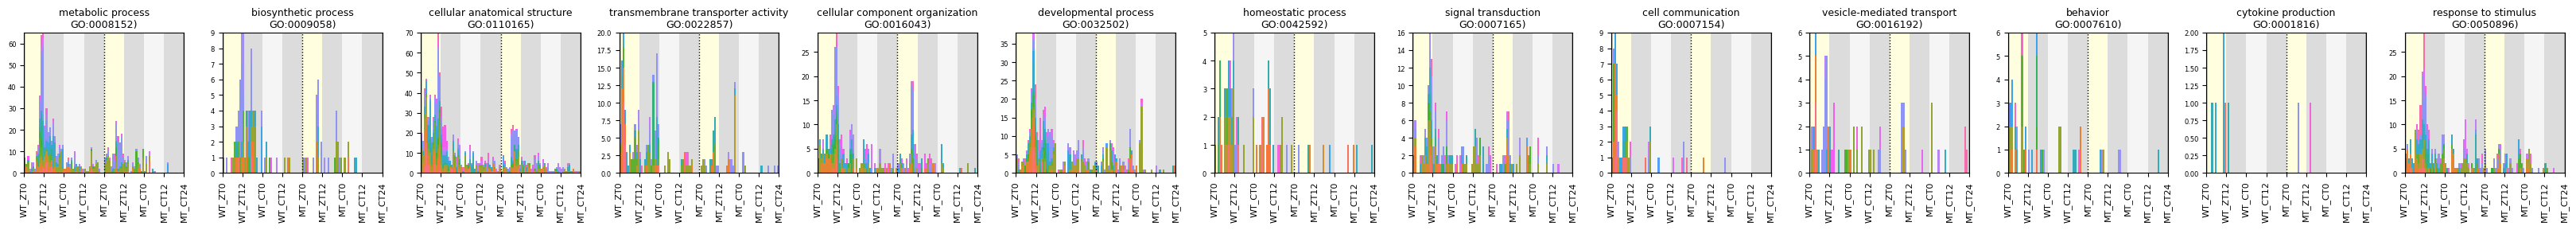

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------------------------
# Data and setup (same as before)
# ----------------------------------------------------------------------------
df_long = df_long[df_long["CellType"] != "Unannotated"]

desired_cluster_order = [
    "metabolic process (GO:0008152)",
    "biosynthetic process (GO:0009058)",#
    "cellular anatomical structure (GO:0110165)",
    "transmembrane transporter activity (GO:0022857)",
    "cellular component organization (GO:0016043)",
    "developmental process (GO:0032502)",
    "homeostatic process (GO:0042592)",
    "signal transduction (GO:0007165)",#
    "cell communication (GO:0007154)",#
    "vesicle-mediated transport (GO:0016192)",#
    "behavior (GO:0007610)",#
    "cytokine production (GO:0001816)",#
    "response to stimulus (GO:0050896)"#
]

go_columns = [
    'Current_Term', 'Higher_Parent_Term', 'Second_Higher_Parent_Term', 
    'Third_Higher_Parent_Term', 'Fourth_Higher_Parent_Term', 
    'Fifth_Higher_Parent_Term', 'Sixth_Higher_Parent_Term',
    'Seventh_Higher_Parent_Term','Eighth_Higher_Parent_Term',
    'Ninth_Higher_Parent_Term','Tenth_Higher_Parent_Term',
    'Eleventh_Higher_Parent_Term'
]

def find_matching_term(row):
    for col in go_columns:
        value = row[col]
        if pd.notna(value):
            for term in desired_cluster_order:
                if term in value:
                    return term
    return np.nan

df_long['Cluster_converted'] = df_long.apply(find_matching_term, axis=1)
clusters_in_data = df_long["Cluster_converted"].dropna().unique()
clusters_ordered = [c for c in desired_cluster_order if c in clusters_in_data]

celltypes = df_long["CellType"].unique()
palette = sns.color_palette("husl", n_colors=len(celltypes))
celltype_to_color = dict(zip(celltypes, palette))

# ----------------------------------------------------------------------------
# Plot bottom summary only with independent y-axis per GO term
# ----------------------------------------------------------------------------
fig, axes = plt.subplots(1, len(clusters_ordered), figsize=(len(clusters_ordered)*2.5, 3), sharey=False)

for j, (cluster, ax) in enumerate(zip(clusters_ordered, axes)):
    # Shading background
    for start, color in zip([0,12,24,36,48,60,72,84], 
                            ['lightyellow', 'gainsboro', 'whitesmoke', 'gainsboro',
                             'lightyellow', 'gainsboro', 'whitesmoke', 'gainsboro']):
        ax.axvspan(start, start+12, facecolor=color, edgecolor='none', alpha=1, zorder=0)
    
    bin_edges = np.arange(0, 97, 1)
    bottom_array = np.zeros(len(bin_edges) - 1)

    for ctype in celltypes:
        times = df_long.loc[
            (df_long["Cluster_converted"] == cluster) & 
            (df_long["CellType"] == ctype),
            "ContinuousTime"
        ]
        counts, _ = np.histogram(times, bins=bin_edges)
        ax.bar(
            bin_edges[:-1], counts,
            bottom=bottom_array,
            color=celltype_to_color[ctype],
            width=1, align='edge', edgecolor='none'
        )
        bottom_array += counts

    # Vertical lines
    ax.axvline(x=0,  color='black', linestyle='-', linewidth=1.0)
    ax.axvline(x=48, color='black', linestyle=':', linewidth=1.0)
    ax.axvline(x=96, color='black', linestyle='-', linewidth=1.0)

    # Axis formatting
    ax.set_xlim(0, 96)
    ax.set_xticks([0, 12, 24, 36, 48, 60, 72, 84, 96])
    ax.set_xticklabels(
        ["WT_ZT0", "WT_ZT12", "WT_CT0", "WT_CT12", 
         "MT_ZT0", "MT_ZT12", "MT_CT0", "MT_CT12", "MT_CT24"],
        fontsize=8, rotation=90
    )
    ax.tick_params(axis='y', labelsize=6)
    ax.set_title("\n".join(cluster.split(" (")), fontsize=9, pad=5)

plt.tight_layout()
plt.show()


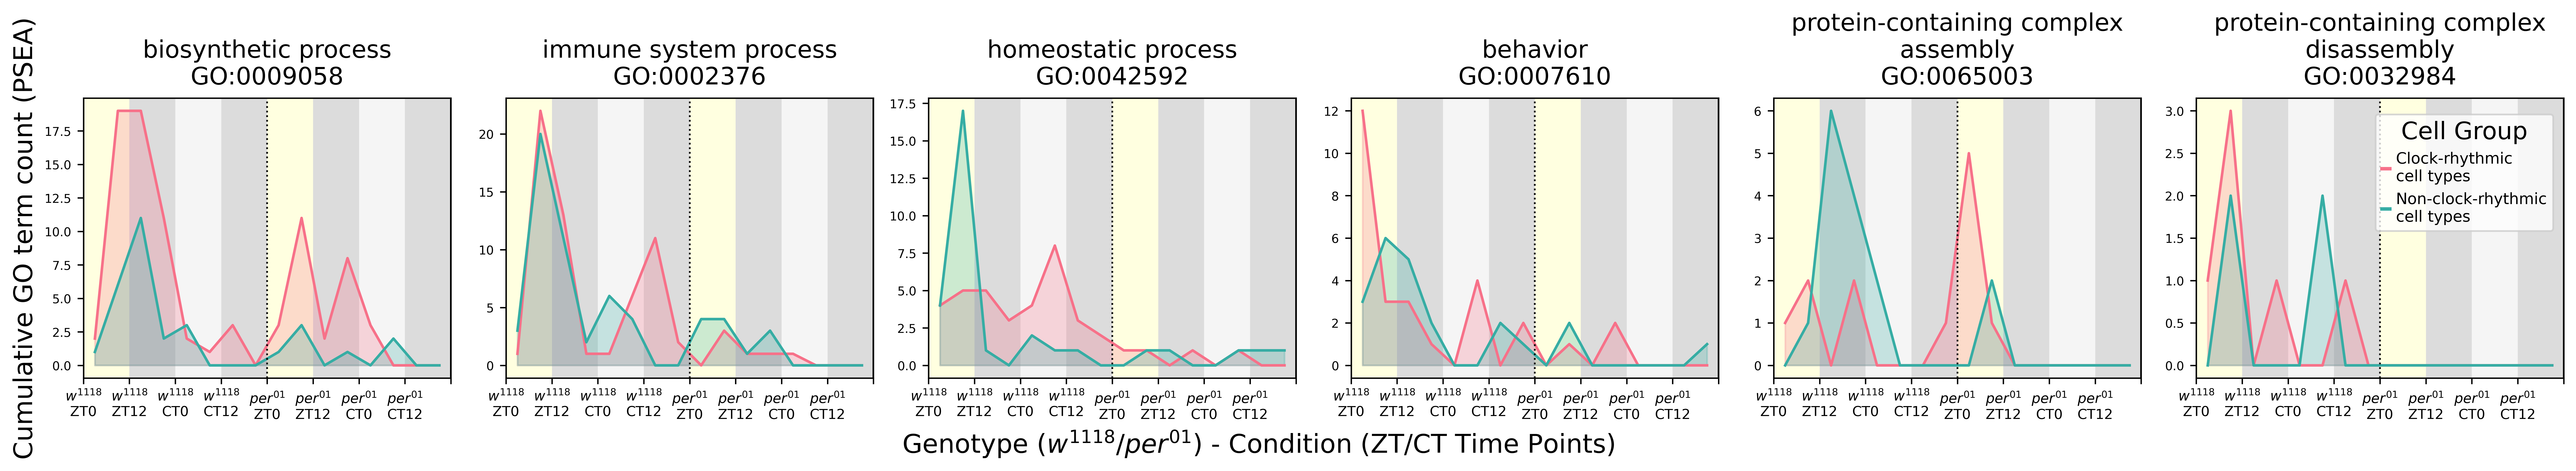

In [13]:
# --- parameters you can tweak ---
bin_width   = 6
fill_alpha  = 0.25
n_rows      = 1                      # two-row layout
right_pad   = 1                   # space for legend (0..1)

import textwrap

desired_cluster_order = [
    "biosynthetic process (GO:0009058)",
    "immune system process (GO:0002376)",
    "homeostatic process (GO:0042592)",
    "behavior (GO:0007610)",
#    "signal transduction (GO:0007165)",
    "protein-containing complex assembly (GO:0065003)",
    "protein-containing complex disassembly (GO:0032984)",
#    "monoatomic cation transmembrane transport (GO:0098655)",
#    "neurotransmitter transport (GO:0006836)",

#    "cell surface receptor protein tyrosine kinase signaling pathway (GO:0007169)",
#    "cell surface receptor protein serine/threonine kinase signaling pathway (GO:0007178)",
#    "enzyme-linked receptor protein signaling pathway (GO:0007167)",
#    "intracellular signal transduction (GO:0035556)",
#    "G protein-coupled receptor signaling pathway (GO:0007186)",
]

go_columns = [
    'Current_Term','Higher_Parent_Term','Second_Higher_Parent_Term',
    'Third_Higher_Parent_Term','Fourth_Higher_Parent_Term',
    'Fifth_Higher_Parent_Term','Sixth_Higher_Parent_Term',
    'Seventh_Higher_Parent_Term','Eighth_Higher_Parent_Term',
    'Ninth_Higher_Parent_Term','Tenth_Higher_Parent_Term',
    'Eleventh_Higher_Parent_Term'
]

def find_matching_term(row):
    for col in go_columns:
        v = row[col]
        if pd.notna(v):
            for term in desired_cluster_order:
                if term in v:
                    return term
    return np.nan

df_long['Cluster_converted'] = df_long.apply(find_matching_term, axis=1)
clusters_in_data = df_long["Cluster_converted"].dropna().unique()
clusters_ordered = [c for c in desired_cluster_order if c in clusters_in_data]

# ---- layout: 2 rows, ceil(n/2) cols; NO y sharing ----
nC   = len(clusters_ordered)
ncol = int(np.ceil(nC / n_rows))
fig_w = max(8, ncol * 3.5)
fig_h = max(1, n_rows * 3.0)
fig, axes = plt.subplots(n_rows, ncol, figsize=(fig_w, fig_h),
                         sharex=False, sharey=False)    # <-- no y sharing
axes = np.atleast_2d(axes)

colors = sns.color_palette("husl", n_colors=2)

# increase bottom to make room for the supxlabel
plt.subplots_adjust(left=0.05,
                    right=0.95,
                    top=0.95,
                    bottom=0.20,   # adjust as needed
                    wspace=0.20)

def make_edges(width, start=0, stop=96):
    edges = np.arange(start, stop + width, width)
    if edges[-1] != stop:
        edges = np.append(edges, stop)
    return edges

def format_title(term, width=28):
    # Wrap name nicely; GO ID on its own line
    if " (GO:" in term:
        name, go = term.split(" (GO:")
        go = "GO:" + go.rstrip(")")
    else:
        name, go = term, None
    name_wrapped = textwrap.fill(name, width=width,
                                 break_long_words=False,
                                 break_on_hyphens=False)
    return f"{name_wrapped}\n{go}" if go else name_wrapped

def plot_one_axes(ax, cluster, bin_width):
    # background bands
    for start, color in zip([0,12,24,36,48,60,72,84],
                            ['lightyellow','gainsboro','whitesmoke','gainsboro',
                             'lightyellow','gainsboro','whitesmoke','gainsboro']):
        ax.axvspan(start, start+12, facecolor=color, edgecolor='none', alpha=1, zorder=0)

    edges   = make_edges(bin_width, 0, 96)
    centers = edges[:-1] + bin_width/2.0


    # 2) Define rhythmic vs non-rhythmic
    rhythmic_cell_types = {
    "FAT-1","FAT-2","HE","ALG","CHG","PNG","SPG",
    "CG","EG","LEMG","CONE-1","CONE-2","R1-6","R7","R8","CLKN","KCy",
    "PGM","DRA","OCR","T1","EPI"
    }
    all_ct = df_long.CellType.unique()
    non_rhythmic_cell_types = [ct for ct in all_ct if ct not in rhythmic_cell_types]

    mask = (df_long["Cluster_converted"] == cluster)
    rt = df_long.loc[mask & df_long["CellType"].isin(rhythmic_cell_types), "ContinuousTime"]
    nt = df_long.loc[mask & df_long["CellType"].isin(non_rhythmic_cell_types), "ContinuousTime"]

    r_counts, _ = np.histogram(rt, bins=edges)
    n_counts, _ = np.histogram(nt, bins=edges)

    # continuous line + area directly under the line
    ax.plot(centers, r_counts, color=colors[0], lw=1.5, zorder=2)
    ax.fill_between(centers, r_counts, 0, color=colors[0], alpha=fill_alpha,
                    zorder=1, interpolate=True)

    ax.plot(centers, n_counts, color=colors[1], lw=1.5, zorder=2)
    ax.fill_between(centers, n_counts, 0, color=colors[1], alpha=fill_alpha,
                    zorder=1, interpolate=True)

    # reference lines
    ax.axvline(x=0,  color='black', linestyle='-', linewidth=1.0)
    ax.axvline(x=48, color='black', linestyle=':', linewidth=1.0)
    ax.axvline(x=96, color='black', linestyle='-', linewidth=1.0)

    ax.set_xlim(0, 96)
    ax.set_xticks([0,12,24,36,48,60,72,84,96])
    ax.set_xticklabels(
    [r"$w^{1118}$" + "\nZT0", r"$w^{1118}$" + "\nZT12", r"$w^{1118}$" + "\nCT0", r"$w^{1118}$" + "\nCT12",
     r"$per^{01}$" + "\nZT0", r"$per^{01}$" + "\nZT12", r"$per^{01}$" + "\nCT0", r"$per^{01}$" + "\nCT12", ""],
    fontsize=8
    )
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(False)
    ax.set_title(format_title(cluster), fontsize=20)

# draw panels
for i, cluster in enumerate(clusters_ordered):
    r = i // ncol
    c = i %  ncol
    ax = axes[r, c]
    plot_one_axes(ax, cluster, bin_width)
    ax.set_title(format_title(cluster), fontsize=14, pad=8)

# hide unused axes
for k in range(nC, n_rows*ncol):
    r = k // ncol; c = k % ncol
    axes[r, c].axis('off')

# legend in the reserved right margin
handles = [plt.Line2D([0],[0], color=colors[0], lw=2),
           plt.Line2D([0],[0], color=colors[1], lw=2)]
labels  = ["Clock-rhythmic\ncell types", "Non-clock-rhythmic\ncell types"]
fig.legend(handles, labels, title="Cell Group",
           loc='center left', bbox_to_anchor=(right_pad-0.075, 0.75),
           fontsize=9)

# Add x-axis label
fig.text(0.5, 0.00,
         r"Genotype ($w^{1118}$/$per^{01}$) - Condition (ZT/CT Time Points)",
         ha='center',
         fontsize=15)

# left y-labels
for r in range(n_rows):
    axes[r, 0].set_ylabel("Cumulative GO term count (PSEA)", fontsize=15)

plt.subplots_adjust(right=right_pad, wspace=0.15, hspace=0.6)
plt.show()


In [11]:
sc.set_figure_params(dpi = 300)

In [99]:
import pandas as pd

# Define the GO hierarchy columns
go_columns = [
    'Current_Term', 
    'Higher_Parent_Term', 'Second_Higher_Parent_Term', 
    'Third_Higher_Parent_Term', 'Fourth_Higher_Parent_Term', 
    'Fifth_Higher_Parent_Term', 'Sixth_Higher_Parent_Term',
    'Seventh_Higher_Parent_Term','Eighth_Higher_Parent_Term',
    'Ninth_Higher_Parent_Term','Tenth_Higher_Parent_Term',
    'Eleventh_Higher_Parent_Term'
]

def get_direct_child_counts(df, parent_term, go_columns):
    """
    For each row in df, if one of the columns in go_columns (except the first)
    equals the parent_term, then the value in the column immediately to its left
    is considered a direct child term of parent_term.
    Returns a Series with counts for each direct child term.
    """
    child_counts = {}
    # Start from the second column (index 1) since index 0 has no preceding column
    for i in range(1, len(go_columns)):
        col = go_columns[i]
        prev_col = go_columns[i-1]
        # Create a boolean mask where the current column equals the parent_term
        mask = df[col] == parent_term
        # Extract the candidate child terms from the previous column
        child_terms = df.loc[mask, prev_col]
        # Count frequencies and aggregate into child_counts dictionary
        counts = child_terms.value_counts(dropna=False)
        for term, count in counts.items():
            # Optionally, ignore NaN or the parent_term itself if it appears
            if pd.isna(term) or term == parent_term:
                continue
            child_counts[term] = child_counts.get(term, 0) + count
    return pd.Series(child_counts).sort_values(ascending=False)

# Define the high-level terms (using your formatted strings)



"cell surface receptor protein tyrosine kinase signaling pathway (GO:0007169)"
"cell surface receptor protein serine/threonine kinase signaling pathway (GO:0007178)"
cco = "enzyme-linked receptor protein signaling pathway (GO:0007167)"
loc = "intracellular signal transduction (GO:0035556)"
dev = "G protein-coupled receptor signaling pathway (GO:0007186)"
mop = "neurotransmitter transport (GO:0006836)"  
abc = "signal transduction (GO:0007165)"

# Get the direct child term counts for each high-level term
cco = get_direct_child_counts(df_long, cco, go_columns)
loc = get_direct_child_counts(df_long, loc, go_columns)
dev = get_direct_child_counts(df_long, dev, go_columns)
mop = get_direct_child_counts(df_long, mop, go_columns)
abc = get_direct_child_counts(df_long, abc, go_columns)

# Print the results
print("Direct child terms of cellular component organization (GO:0016043):")
print(cco)
print("\nDirect child terms of localization (GO:0051179):")
print(loc)
print("\nDirect child terms of developmental process (GO:0032502):")
print(dev)
print("\nDirect child terms of multicellular organismal process (GO:0032501):")
print(mop)
print("\nDirect child terms of multicellular organismal process (GO:0032501):")
print(abc)


Direct child terms of cellular component organization (GO:0016043):
cell surface receptor protein tyrosine kinase signaling pathway (GO:0007169)            24
cell surface receptor protein serine/threonine kinase signaling pathway (GO:0007178)    11
dtype: int64

Direct child terms of localization (GO:0051179):
intracellular signaling cassette (GO:0141124)             41
intrinsic apoptotic signaling pathway (GO:0097193)         8
intracellular receptor signaling pathway (GO:0030522)      6
signal transduction by p53 class mediator (GO:0072331)     5
cell cycle checkpoint signaling (GO:0000075)               4
hippo signaling (GO:0035329)                               1
protein kinase C signaling (GO:0070528)                    1
TOR signaling (GO:0031929)                                 1
dtype: int64

Direct child terms of developmental process (GO:0032502):
adenylate cyclase-modulating G protein-coupled receptor signaling pathway (GO:0007188)    6
neuropeptide signaling pathway (GO:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# —— Assumes df_long already exists with:
#    • df_long.CellType
#    • df_long.Cluster_converted   # one of six GO terms
#    • df_long.ContinuousTime      # values 0…96

# 1) GO-term order
clusters = [
    "metabolic process (GO:0008152)",
    "cellular anatomical structure (GO:0110165)",
    "transmembrane transporter activity (GO:0022857)",
    "cellular component organization (GO:0016043)",
    "developmental process (GO:0032502)",
    "homeostatic process (GO:0042592)",
]
clusters = [c for c in clusters if c in df_long.Cluster_converted.unique()]

# 2) Define rhythmic vs non-rhythmic
rhythmic = {
    "FAT-1","FAT-2","HE","L1","L2","L3","LAWF1","OCHG","ALG","CHG","PNG","SPG",
    "CG","EG","LEMG","JON","CONE-1","CONE-2","R1-6","R7","R8","CLKN","KCy",
    "PGM","DRA","OCR","T1","EPI"
}
all_ct = df_long.CellType.unique()
non_rhythmic = [ct for ct in all_ct if ct not in rhythmic]

# 3) Palettes
pal_top = sns.color_palette("husl", n_colors=len(all_ct))
map_top = dict(zip(all_ct, pal_top))
pal_bot = sns.color_palette("husl", n_colors=2)

# 4) Time bins
bins = np.arange(0, 97, 1)

# 5) Create 2×N subplots with tighter spacing & shorter height
n = len(clusters)

# … right after you create your figure …
fig, axes = plt.subplots(2, n, figsize=(n * 2.5, 5), sharex='col')

# increase bottom to make room for the supxlabel
plt.subplots_adjust(left=0.05,
                    right=0.95,
                    top=0.95,
                    bottom=0.20,   # ← was 0.1
                    hspace=0.1,
                    wspace=0.2)

for col, go in enumerate(clusters):
    # — Top row: all cell types —
    ax = axes[0, col]
    bottom = np.zeros(len(bins) - 1)
    for ct in all_ct:
        times = df_long.query("Cluster_converted == @go and CellType == @ct")["ContinuousTime"]
        cnt, _ = np.histogram(times, bins=bins)
        ax.bar(
            bins[:-1], cnt, bottom=bottom,
            width=1, align='edge',
            color=map_top[ct], edgecolor='none', zorder=2
        )
        bottom += cnt

    # — Bottom row: rhythmic vs non-rhythmic —
    axb = axes[1, col]
    rt = df_long.query("Cluster_converted == @go and CellType in @rhythmic")["ContinuousTime"]
    nr = df_long.query("Cluster_converted == @go and CellType in @non_rhythmic")["ContinuousTime"]
    crt, _ = np.histogram(rt, bins=bins)
    cnr, _ = np.histogram(nr, bins=bins)
    axb.bar(
        bins[:-1], crt, width=1, align='edge',
        color=pal_bot[0], edgecolor='none', zorder=2
    )
    axb.bar(
        bins[:-1], cnr, bottom=crt, width=1, align='edge',
        color=pal_bot[1], edgecolor='none', zorder=2
    )

    # — Shared shading & dividers (behind bars) —
    for a in (ax, axb):
        for start, shade in zip(
            [0, 12, 24, 36, 48, 60, 72, 84],
            ['lightyellow', 'gainsboro', 'whitesmoke', 'gainsboro',
             'lightyellow', 'gainsboro', 'whitesmoke', 'gainsboro']
        ):
            a.axvspan(start, start + 12, facecolor=shade, edgecolor='none', alpha=1, zorder=0)
        a.axvline(0,   color='k', linewidth=1, zorder=1)
        a.axvline(48,  color='black', linestyle=':', linewidth=2, zorder=3)
        a.axvline(96,  color='k', linewidth=1, zorder=1)
        a.set_xlim(0, 96)

    # — Formatting axes & titles —
    # Top: show y-axis ticks & label on first column only
    ax.tick_params(axis='y', labelsize=6)
    if col == 0:
        ax.set_ylabel("Aggregated cell type–specific PSEA count", fontsize=8)
    ax.set_xticks([])

    # Wrap long GO term title for transmembrane
    if "transmembrane transporter activity" in go:
        title = "transmembrane transporter\nactivity\n(GO:0022857)"
    else:
        term, goid = go.split(" (")
        title = f"{term}\n({goid[:-1]})"
    ax.set_title(title, fontsize=9)

    # Bottom: x-labels & y-axis label on first column only
    axb.set_xticks([0, 12, 24, 36, 48, 60, 72, 84])
    axb.set_xticklabels(
        ["WT_ZT0", "WT_ZT12", "WT_CT0", "WT_CT12",
         "MT_ZT0", "MT_ZT12", "MT_CT0", "MT_CT12"],
        rotation=90, fontsize=8
    )
    if col == 0:
        axb.set_ylabel("Aggregated cell type–specific\nPSEA count", fontsize=8)
    axb.tick_params(axis='y', labelsize=6)

fig.text(0.5, 0.02,
         "Genotype (WT/MT) _ Condition (ZT/CT Time Points)",
         ha='center',
         fontsize=12)


# — No legend — 
plt.show()


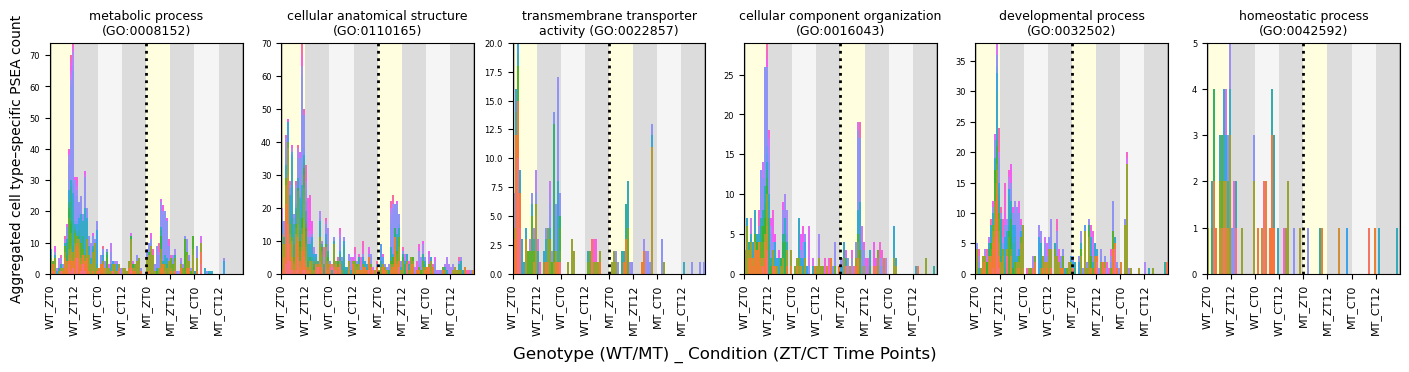

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# —— Assumes df_long already exists with:
#    • df_long.CellType
#    • df_long.Cluster_converted   # one of six GO terms
#    • df_long.ContinuousTime      # values 0…96

# 1) GO-term order
clusters = [
    "metabolic process (GO:0008152)",
    "cellular anatomical structure (GO:0110165)",
    "transmembrane transporter activity (GO:0022857)",
    "cellular component organization (GO:0016043)",
    "developmental process (GO:0032502)",
    "homeostatic process (GO:0042592)",
]
clusters = [c for c in clusters if c in df_long.Cluster_converted.unique()]

# 2) Define rhythmic vs non-rhythmic
rhythmic = {
    "FAT-1","FAT-2","HE","L1","L2","L3","LAWF1","OCHG","ALG","CHG","PNG","SPG",
    "CG","EG","LEMG","JON","CONE-1","CONE-2","R1-6","R7","R8","CLKN","KCy",
    "PGM","DRA","OCR","T1","EPI"
}
all_ct = df_long.CellType.unique()
non_rhythmic = [ct for ct in all_ct if ct not in rhythmic]

# 3) Palettes
pal_top = sns.color_palette("husl", n_colors=len(all_ct))
map_top = dict(zip(all_ct, pal_top))
pal_bot = sns.color_palette("husl", n_colors=2)

# 4) Time bins
bins = np.arange(0, 97, 1)

# 5) Create 1×N subplots instead of 2×N
fig, axes = plt.subplots(1, n, figsize=(n * 2.5, 3), sharex='col')

# increase bottom to make room for the supxlabel
plt.subplots_adjust(left=0.05,
                    right=0.95,
                    top=1.1,
                    bottom=0.33,   # adjust as needed
                    wspace=0.20)

for col, go in enumerate(clusters):
    ax = axes[col]
    bottom = np.zeros(len(bins) - 1)
    for ct in all_ct:
        times = df_long.query("Cluster_converted == @go and CellType == @ct")["ContinuousTime"]
        cnt, _ = np.histogram(times, bins=bins)
        ax.bar(
            bins[:-1], cnt, bottom=bottom,
            width=1, align='edge',
            color=map_top[ct], edgecolor='none', zorder=2
        )
        bottom += cnt

    # — Background shading & dividers —
    for start, shade in zip(
        [0, 12, 24, 36, 48, 60, 72, 84],
        ['lightyellow', 'gainsboro', 'whitesmoke', 'gainsboro',
         'lightyellow', 'gainsboro', 'whitesmoke', 'gainsboro']
    ):
        ax.axvspan(start, start + 12, facecolor=shade, edgecolor='none', alpha=1, zorder=0)
    ax.axvline(0, color='k', linewidth=1, zorder=1)
    ax.axvline(48, color='black', linestyle=':', linewidth=2, zorder=3)
    ax.axvline(96, color='k', linewidth=1, zorder=1)
    ax.set_xlim(0, 96)
    ax.grid(False)
    # — Formatting axes & titles —
    ax.tick_params(axis='y', labelsize=6)
    if col == 0:
        ax.set_ylabel("Aggregated cell type–specific PSEA count", fontsize=10)
    ax.set_xticks([0, 12, 24, 36, 48, 60, 72, 84])
    ax.set_xticklabels(
        ["WT_ZT0", "WT_ZT12", "WT_CT0", "WT_CT12",
         "MT_ZT0", "MT_ZT12", "MT_CT0", "MT_CT12"],
        rotation=90, fontsize=8
    )

    # Wrap long GO term title
    if "transmembrane transporter activity" in go:
        title = "transmembrane transporter\nactivity (GO:0022857)"
    else:
        term, goid = go.split(" (")
        title = f"{term}\n({goid[:-1]})"
    ax.set_title(title, fontsize=9)

# Add x-axis label
fig.text(0.5, 0.05,
         "Genotype (WT/MT) _ Condition (ZT/CT Time Points)",
         ha='center',
         fontsize=12)

plt.show()


In [35]:
# Get the direct child term counts for each high-level term
biological_regulation = "biological_process (GO:0008150)"
bio_reg_child_counts = get_direct_child_counts(df_long, biological_regulation, go_columns)
print("\nDirect child terms of biological regulation (GO:0065007):")
print(bio_reg_child_counts)


Direct child terms of biological regulation (GO:0065007):
biological regulation (GO:0065007)                                                        2722
cellular process (GO:0009987)                                                             2416
developmental process (GO:0032502)                                                         747
localization (GO:0051179)                                                                  556
response to stimulus (GO:0050896)                                                          511
multicellular organismal process (GO:0032501)                                              283
immune system process (GO:0002376)                                                         113
homeostatic process (GO:0042592)                                                            81
reproductive process (GO:0022414)                                                           53
growth (GO:0040007)                                                                   